### Installation

In [1]:
!gdown 1aPtVU8N22ZZtkfa1yCmHui0oNEkwv9U8

Downloading...
From (original): https://drive.google.com/uc?id=1aPtVU8N22ZZtkfa1yCmHui0oNEkwv9U8
From (redirected): https://drive.google.com/uc?id=1aPtVU8N22ZZtkfa1yCmHui0oNEkwv9U8&confirm=t&uuid=f70f2f3c-f1c1-4ccd-a089-1921ca26e555
To: /content/Humans.zip
100% 36.4M/36.4M [00:00<00:00, 39.5MB/s]


In [2]:
!unzip Humans.zip

Archive:  Humans.zip
   creating: Humans/
   creating: Humans/Images/
  inflating: Humans/Images/1.png     
  inflating: Humans/Images/10.png    
  inflating: Humans/Images/100.png   
  inflating: Humans/Images/11.png    
  inflating: Humans/Images/12.png    
  inflating: Humans/Images/13.png    
  inflating: Humans/Images/14.png    
  inflating: Humans/Images/15.png    
  inflating: Humans/Images/16.png    
  inflating: Humans/Images/17.png    
  inflating: Humans/Images/18.png    
  inflating: Humans/Images/19.png    
  inflating: Humans/Images/2.png     
  inflating: Humans/Images/20.png    
  inflating: Humans/Images/21.png    
  inflating: Humans/Images/22.png    
  inflating: Humans/Images/23.png    
  inflating: Humans/Images/24.png    
  inflating: Humans/Images/25.png    
  inflating: Humans/Images/26.png    
  inflating: Humans/Images/27.png    
  inflating: Humans/Images/28.png    
  inflating: Humans/Images/29.png    
  inflating: Humans/Images/3.png     
  inflating: Human

### DataPrep

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

IMG_SIZE = (224, 224)

def load_yolo_annotations(txt_file, img_size):
    h, w = img_size
    with open(txt_file, 'r') as f:
        lines = f.readlines()

    if not lines:
        return np.array([0, 0, 0, 0, 0])
    class_id, x_center, y_center, bbox_w, bbox_h = map(float, lines[0].split())
    return np.array([class_id, x_center, y_center, bbox_w, bbox_h])


def load_dataset(img_dir, ann_dir, img_size=(224, 224)):
    """Load images and corresponding bounding boxes."""
    images, class_labels, bbox_labels = [], [], []

    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        ann_path = os.path.join(ann_dir, img_file.replace('.png', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size) / 255.0
        annotations = load_yolo_annotations(ann_path, img_size)

        images.append(img)
        class_labels.append(annotations[0])
        bbox_labels.append(annotations[1:])

    return np.array(images), np.array(class_labels).reshape(-1, 1), np.array(bbox_labels)


### Modelling

In [4]:
def ssd_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    class_out = Dense(num_classes, activation='sigmoid', name='class_out')(x)

    bbox_out = Dense(4, activation='sigmoid', name='bbox_out')(x)

    return Model(inputs, [class_out, bbox_out])



In [5]:
def ssd_loss(y_true, y_pred):
    bbox_loss = tf.reduce_mean(tf.keras.losses.Huber()(y_true[:, :4], y_pred[:, :4]))
    return bbox_loss


### Model Training

In [6]:
# Load Dataset
img_dir = "/content/Humans/Images"
ann_dir = "/content/Humans/Labels"
images, class_labels, bbox_labels = load_dataset(img_dir, ann_dir)
print(images.shape,class_labels.shape,bbox_labels.shape)

(100, 224, 224, 3) (100, 1) (100, 4)


In [7]:

model = ssd_model()

model.compile(
    optimizer='adam',
    loss={'class_out': 'binary_crossentropy', 'bbox_out': 'mse'},
    metrics={'class_out': ['accuracy'], 'bbox_out': ['mse']}
)

model.fit(
    images,
    {'class_out': class_labels, 'bbox_out': bbox_labels},
    epochs=15, batch_size=8, validation_split=0.2
)

model.save("ssd_model.h5")

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - bbox_out_loss: 0.1135 - bbox_out_mse: 0.1135 - class_out_accuracy: 0.8967 - class_out_loss: 0.1916 - loss: 0.3051 - val_bbox_out_loss: 0.0313 - val_bbox_out_mse: 0.0322 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.0055 - val_loss: 0.0384
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - bbox_out_loss: 0.0316 - bbox_out_mse: 0.0316 - class_out_accuracy: 1.0000 - class_out_loss: 0.0012 - loss: 0.0328 - val_bbox_out_loss: 0.0330 - val_bbox_out_mse: 0.0354 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.0594e-05 - val_loss: 0.0354
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - bbox_out_loss: 0.0283 - bbox_out_mse: 0.0283 - class_out_accuracy: 1.0000 - class_out_loss: 3.5069e-06 - loss: 0.0283 - val_bbox_out_loss: 0.0315 - val_bbox_out_mse: 0.0322 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 4.4294e-05 - val_loss: 0.0322
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - bbox_out_loss: 0.0269 - 

### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[7.84143e-08]]


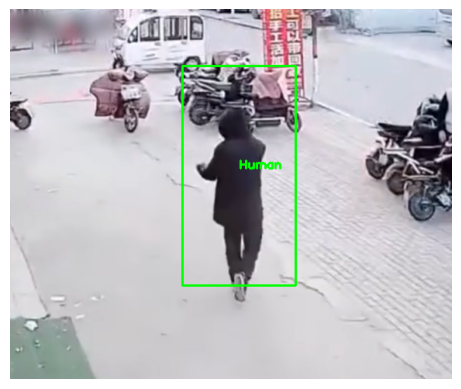

In [8]:
import matplotlib.pyplot as plt

def predict_and_display(image_path, model):

    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    class_pred, bbox_pred = model.predict(img_input)
    print(class_pred)
    class_label = "Human"
    x, y, w, h = bbox_pred[0] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])

    if w > 0 and h > 0:
        cv2.rectangle(img, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), (0, 255, 0), 2)
        cv2.putText(img, class_label, (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

predict_and_display("/content/Humans/Images/98.png", model)

In [9]:
import tensorflow as tf

y_true = tf.constant([[0.5, 0.4, 0.3, 0.2], [0.6, 0.5, 0.4, 0.3]], dtype=tf.float32)
y_pred = tf.constant([[0.4, 0.35, 0.25, 0.15], [0.7, 0.6, 0.5, 0.4]], dtype=tf.float32)

huber_loss = tf.keras.losses.Huber(delta=1.0)
loss_value = huber_loss(y_true, y_pred)

print("Huber Loss:", loss_value.numpy())

Huber Loss: 0.0035937498


### Stereo Depth System

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def PredictDepth(img1, img2, model):

    img1 = img1
    img2 = img2

    imgre1 = cv2.resize(img1, (224, 224)) / 255.0
    imgre2 = cv2.resize(img2, (224, 224)) / 255.0

    imginp1 = np.expand_dims(imgre1, axis=0)
    imginp2 = np.expand_dims(imgre2, axis=0)

    pred1, bbox1 = model.predict(imginp1)
    pred2, bbox2 = model.predict(imginp2)

    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

    cx1, cy1, width1, height1 = (bbox1[0] * np.array([w1, h1, w1, h1])).astype(int)
    cx2, cy2, width2, height2 = (bbox2[0] * np.array([w2, h2, w2, h2])).astype(int)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cv2.rectangle(img1, (cx1 - width1//2, cy1 - height1//2), (cx1 + width1//2, cy1 + height1//2), (0, 255, 0), 2)
    cv2.putText(img1, "HUMAN", (cx1, cy1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.rectangle(img2, (cx2 - width2//2, cy2 - height2//2), (cx2 + width2//2, cy2 + height2//2), (0, 255, 0), 2)
    cv2.putText(img2, "HUMAN", (cx2, cy2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    disparity = abs(cx1 - cx2)

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis("off")
    plt.show()
    return disparity,abs(cx1-cx2)

img1=cv2.imread("/content/Humans/Images/99.png")
def translate_image(img, shift_x, shift_y):
    height, width = img.shape[:2]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    translated_img = cv2.warpAffine(img, translation_matrix, (width, height))
    return translated_img

img2=translate_image(img1, 50,0)
baselength=2
Depth1,x1=(baselength*996)/PredictDepth(img1, img2, model)

In [ ]:
print(f"Depth of Object Found will be {Depth1}cm")

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def PredictDepth(img1, img2, model):

    img1 = img1
    img2 = img2

    imgre1 = cv2.resize(img1, (224, 224)) / 255.0
    imgre2 = cv2.resize(img2, (224, 224)) / 255.0

    imginp1 = np.expand_dims(imgre1, axis=0)
    imginp2 = np.expand_dims(imgre2, axis=0)

    pred1, bbox1 = model.predict(imginp1)
    pred2, bbox2 = model.predict(imginp2)

    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape

    cx1, cy1, width1, height1 = (bbox1[0] * np.array([w1, h1, w1, h1])).astype(int)
    cx2, cy2, width2, height2 = (bbox2[0] * np.array([w2, h2, w2, h2])).astype(int)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    cv2.rectangle(img1, (cx1 - width1//2, cy1 - height1//2), (cx1 + width1//2, cy1 + height1//2), (0, 255, 0), 2)
    cv2.putText(img1, "HUMAN", (cx1, cy1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.rectangle(img2, (cx2 - width2//2, cy2 - height2//2), (cx2 + width2//2, cy2 + height2//2), (0, 255, 0), 2)
    cv2.putText(img2, "HUMAN", (cx2, cy2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    disparity = abs(cx1 - cx2)

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis("off")
    plt.show()
    return disparity,abs(cx1-cx2)

img1=cv2.imread("/content/Humans/Images/99.png")
def translate_image(img, shift_x, shift_y):
    height, width = img.shape[:2]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    translated_img = cv2.warpAffine(img, translation_matrix, (width, height))
    return translated_img

img2=translate_image(img1, 70,0)
baselength=2
Depth2,x2=(baselength*996)/PredictDepth(img1, img2, model)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
print(f"Depth of Object Found will be {Depth2}cm")

### Lstm for Smooth Calculation

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("Speed.csv")

# Extract input (X) and output (Y)
X = df[['Depth_1', 'Depth_2', 'X1', 'X2']].values
Y = df[['Speed', 'Turn']].values

# Normalize data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y)

# Reshape input for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 4)),
    Dense(25, activation='relu'),
    Dense(2)  # Output layer for Speed and Turn
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_test, Y_test))

# Evaluate model
loss = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")

In [36]:

def predict_speed_and_turn(depth_1, depth_2, x1, x2):
    input_data = np.array([[depth_1, depth_2, x1, x2]])
    input_data = scaler_X.transform(input_data)
    input_data = input_data.reshape((1, 1, 4))
    predicted_values = model.predict(input_data)
    predicted_values = scaler_Y.inverse_transform(predicted_values)
    return predicted_values[0, 0], predicted_values[0, 1]


In [40]:

# Example prediction
depth_1, depth_2, x1, x2 = Depth1,Depth2,x1,x2
predicted_speed, predicted_turn = predict_speed_and_turn(depth_1, depth_2, x1, x2)
print(f"Predicted Speed: {predicted_speed:.2f}, Predicted Turn: {predicted_turn:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Speed: 1.44, Predicted Turn: 5.84


In [42]:
# Example prediction
depth_1, depth_2, x1, x2 = 20, 22, 50, 55
predicted_speed, predicted_turn = predict_speed_and_turn(depth_1, depth_2, x1, x2)
print(f"Predicted Speed: {predicted_speed:.2f}, Predicted Turn: {predicted_turn:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Speed: 4.07, Predicted Turn: 4.66
